1) Familiarize yourself with Pennylane. The tutorials in the Pennylane
codebook are a good way to get started. We recommend the codebooks
from the sections “Introduction to Quantum Computing”, “Single-Qubit
Gates” and “Circuits with Many Qubits”, which can be found on the following
page (registration is required): Pennylane Codebook.

2) (necessary to pass the project) To familiarize yourself with the basic
workflow in Quantum Machine Learning, work through the tutorial on
Variational Classifier. Implement and present the usual steps in this
workflow and explain in your own words the purpose of each step.

3) (necessary to pass the project) Consider a more sophisticated model using
an interesting real-world dataset (here the MNIST dataset), Quanvolutional
Neural Networks. Work through the example, Implement and present your
steps in a notebook and comment on the important steps.

4) (challenging sub-task) The goal of this subtask is to develop your own
model and use it to learn the sine function on the interval [0, 2π]. Discretize
the interval with a suitable number of points (of your choice) and use the
values of the sine function at these discretization points as labels.
Implement a Quantum Machine Learning model which reproduces the
values of the sine function.

5) (very challenging sub-task) We change the data set from the sine function
to real-word data-set from the industry. Download the following data-set
from kaggle: data. You can find more information about the data set in the
following paper.

Implement a Quantum Machine Learning model to detect a defective
production part. The implementation includes the preprocessing of the
data, the implementation of a model and the visualization of the results. You
can use one of the models above. Further, you can also use only a subset
of the downloaded data. The final deliverable should be a notebook in which
all the necessary steps have been carried out and documented.

# https://drive.google.com/file/d/1AcctFeXjchtEhYzPUsHpP_b4HGlI4kq9/view?pli=1

#TASK-2

Variational Classifier

In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.1 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [3]:
#create quantum device that run the circuit
dev = qml.device("default.qubit")

#Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the full variational circuit.
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

In [4]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [5]:
#define the variational quantum circuit as this state preparation routine, followed by a repetition of the layer structure.
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    for layer_weights in weights:
        layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

In [6]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [7]:
#calculating loss
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [8]:
#calculating accuracy
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

In [9]:
#calculating cost
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [22]:
#Now combining all above the steps and build an usecase of variational classifier

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

# Define the number of qubits and layers
num_qubits = 2
num_layers = 2

# Define the quantum circuit
@qml.qnode(qml.device("default.qubit", wires=num_qubits))
def circuit(weights, x):
    qml.BasisState(x, wires=range(num_qubits))  # Prepare the initial state based on input x
    for W in weights:
        # Apply layers of rotations
        for i in range(num_qubits):
            qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
        # Apply entangling gates
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))  # Measure the expectation value of PauliZ on qubit 0

# Define the variational classifier
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Define the square loss function
def square_loss(labels, predictions):
    loss = np.mean((labels - predictions) ** 2)
    return loss

# Define the accuracy function
def accuracy(labels, predictions):
    predictions = np.sign(predictions)
    return np.mean(predictions == labels)

# Define the cost function
def cost(weights, bias, X, Y):
    predictions = np.array([variational_classifier(weights, bias, x) for x in X])
    return square_loss(Y, predictions)

# Generate a toy dataset
np.random.seed(0)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([1, 1, 0, 0])

# Initialize random weights
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
bias_init = 0.0

# Optimize the cost function
opt = NesterovMomentumOptimizer(0.5)
batch_size = 2
weights = weights_init
bias = bias_init

for it in range(25):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), batch_size)
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(lambda w, b: cost(w, b, X_batch, Y_batch), weights, bias)

    # Compute accuracy
    predictions = np.array([variational_classifier(weights, bias, x).numpy() for x in X])
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )


Iter:     1 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     2 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     3 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     4 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     5 | Cost: 0.4999792 | Accuracy: 0.5000000 
Iter:     6 | Cost: 0.4999201 | Accuracy: 0.5000000 
Iter:     7 | Cost: 0.4993369 | Accuracy: 0.5000000 
Iter:     8 | Cost: 0.4962321 | Accuracy: 0.5000000 
Iter:     9 | Cost: 0.4668007 | Accuracy: 0.5000000 
Iter:    10 | Cost: 0.4319368 | Accuracy: 0.5000000 
Iter:    11 | Cost: 0.3302354 | Accuracy: 0.5000000 
Iter:    12 | Cost: 0.3337832 | Accuracy: 0.5000000 
Iter:    13 | Cost: 0.6857360 | Accuracy: 0.2500000 
Iter:    14 | Cost: 0.5217693 | Accuracy: 0.2500000 
Iter:    15 | Cost: 0.6983571 | Accuracy: 0.2500000 
Iter:    16 | Cost: 0.4204915 | Accuracy: 0.5000000 
Iter:    17 | Cost: 0.2787887 | Accuracy: 0.5000000 
Iter:    18 | Cost: 0.7388964 | Accuracy: 0.2500000 
Iter:    19 | Cost: 0.4793728 | Accuracy: 0.50

Iter:     1 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     2 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     3 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     4 | Cost: 0.4999908 | Accuracy: 0.5000000 
Iter:     5 | Cost: 0.4999792 | Accuracy: 0.5000000 
Iter:     6 | Cost: 0.4999201 | Accuracy: 0.5000000 
Iter:     7 | Cost: 0.4993369 | Accuracy: 0.5000000 
Iter:     8 | Cost: 0.4962321 | Accuracy: 0.5000000 
Iter:     9 | Cost: 0.4668007 | Accuracy: 0.5000000 
Iter:    10 | Cost: 0.4319368 | Accuracy: 0.5000000 
Iter:    11 | Cost: 0.3302354 | Accuracy: 0.5000000 
Iter:    12 | Cost: 0.3337832 | Accuracy: 0.5000000 
Iter:    13 | Cost: 0.6857360 | Accuracy: 0.2500000 
Iter:    14 | Cost: 0.5217693 | Accuracy: 0.2500000 
Iter:    15 | Cost: 0.6983571 | Accuracy: 0.2500000 
Iter:    16 | Cost: 0.4204915 | Accuracy: 0.5000000 
Iter:    17 | Cost: 0.2787887 | Accuracy: 0.5000000 
Iter:    18 | Cost: 0.7388964 | Accuracy: 0.2500000 
Iter:    19 | Cost: 0.4793728 | Accuracy: 0.50

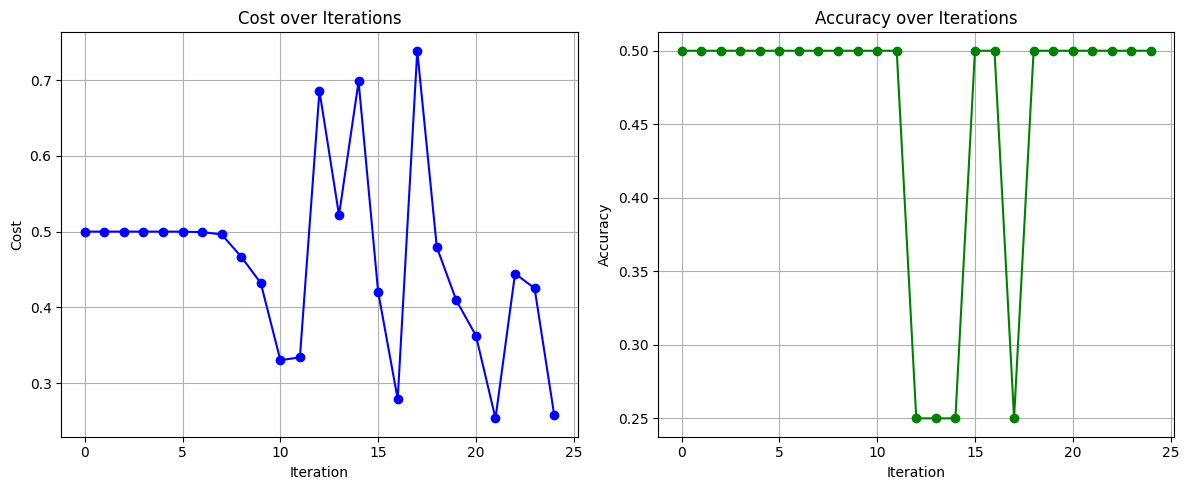

In [24]:
#codes modified and added some plots
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

# Define the number of qubits and layers
num_qubits = 2
num_layers = 2

# Define the quantum circuit
@qml.qnode(qml.device("default.qubit", wires=num_qubits))
def circuit(weights, x):
    qml.BasisState(x, wires=range(num_qubits))  # Prepare the initial state based on input x
    for W in weights:
        # Apply layers of rotations
        for i in range(num_qubits):
            qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
        # Apply entangling gates
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))  # Measure the expectation value of PauliZ on qubit 0

# Define the variational classifier
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Define the square loss function
def square_loss(labels, predictions):
    loss = np.mean((labels - predictions) ** 2)
    return loss

# Define the accuracy function
def accuracy(labels, predictions):
    predictions = np.sign(predictions)
    return np.mean(predictions == labels)

# Define the cost function
def cost(weights, bias, X, Y):
    predictions = np.array([variational_classifier(weights, bias, x) for x in X])
    return square_loss(Y, predictions)

# Generate a toy dataset
np.random.seed(0)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([1, 1, 0, 0])

# Initialize random weights
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
bias_init = 0.0

# Optimize the cost function
opt = NesterovMomentumOptimizer(0.5)
batch_size = 2
weights = weights_init
bias = bias_init

# Lists to store cost and accuracy values
cost_values = []
accuracy_values = []

for it in range(25):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), batch_size)
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(lambda w, b: cost(w, b, X_batch, Y_batch), weights, bias)

    # Compute cost and accuracy
    current_cost = cost(weights, bias, X, Y)
    predictions = np.array([variational_classifier(weights, bias, x).numpy() for x in X])
    acc = accuracy(Y, predictions)

    cost_values.append(current_cost)
    accuracy_values.append(acc)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, current_cost, acc
        )
    )

# Plot cost and accuracy
plt.figure(figsize=(12, 5))

# Plot Cost
plt.subplot(1, 2, 1)
plt.plot(cost_values, marker='o', color='blue', linestyle='-')
plt.title('Cost over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, marker='o', color='green', linestyle='-')
plt.title('Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


# TASK-3

# https://pennylane.ai/qml/demos/tutorial_quanvolution/

The part where it is commented for the sine function it somehow doesn't work for training this but the example mentioned in pennylane tutorial works well

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install torchvision

import numpy as np
import pennylane as qml
import torch
from torchvision import datasets, transforms

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/sample_data"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()



# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)



11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


In [ ]:

# import matplotlib.pyplot as plt
# import pennylane as qml
# import numpy as np

# # Define the number of qubits and layers
# n_qubits = 4
# n_layers = 2

# # Define the state preparation circuit
# def state_preparation(params, n_layers):
#     for i in range(n_layers):
#         qml.RX(params[i * 2], wires=0)
#         qml.RY(params[i * 2 + 1], wires=0)

# # Define the variational circuit
# @qml.qnode(qml.device("default.qubit", wires=n_qubits)) # Define a QNode
# def circuit(params, x): # Add input x
#     state_preparation(params, n_layers)
#     qml.RZ(x, wires=0) # Encode the input x
#     return qml.expval(qml.PauliZ(0))

# # Define the cost function
# def cost(params, x, y):
#     # Calculate the output of the circuit for all x values
#     predictions = [circuit(params, x_val) for x_val in x]

#     # Calculate the mean squared error
#     return np.mean((predictions - y)**2)

# # Define the optimizer
# optimizer = qml.AdamOptimizer(stepsize=0.1)

# # Initialize the parameters
# params = np.random.random(2 * n_layers)

# # Discretize the interval [0, 2π]
# x = np.linspace(0, 2 * np.pi, 100)
# y = np.sin(x)

# # Train the model
# for i in range(100):
#     params = optimizer.step(lambda p: cost(p, x, y), params) # Use a lambda function to pass x and y to cost
#     if (i+1) % 10 == 0:
#         print("Cost at step {:5d}: {: .7f}".format(i+1, cost(params, x, y)))

# # Evaluate the model
# circuit_output = [circuit(params, x_val) for x_val in x]

# # Plot the results
# plt.plot(x, y, label="Sine function")
# plt.plot(x, circuit_output, label="Circuit output")
# plt.legend()
# plt.show()

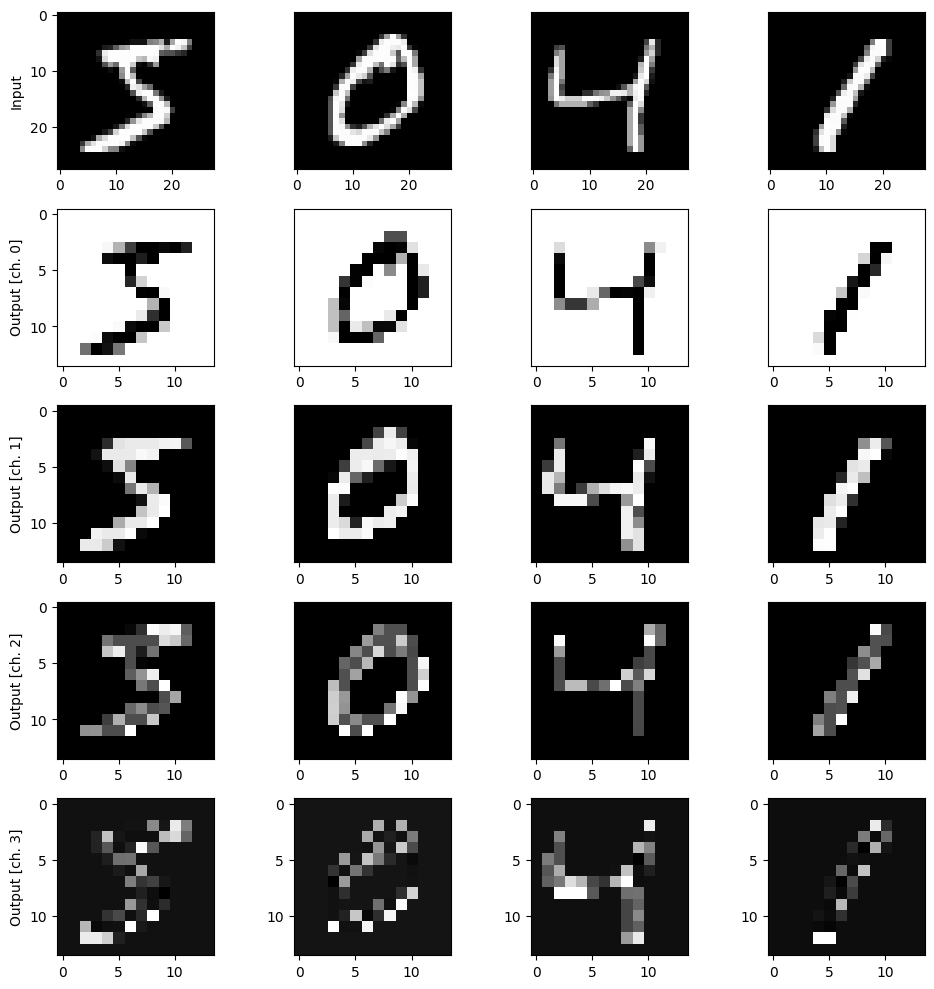

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()



In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.5172 - accuracy: 0.1600 - val_loss: 2.1673 - val_accuracy: 0.2000 - 1s/epoch - 91ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9337 - accuracy: 0.3200 - val_loss: 1.9283 - val_accuracy: 0.4333 - 65ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.5640 - accuracy: 0.5200 - val_loss: 1.8142 - val_accuracy: 0.5667 - 72ms/epoch - 6ms/step
Epoch 4/30
13/13 - 0s - loss: 1.2837 - accuracy: 0.6600 - val_loss: 1.6805 - val_accuracy: 0.6000 - 69ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.0834 - accuracy: 0.8200 - val_loss: 1.5645 - val_accuracy: 0.6667 - 113ms/epoch - 9ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9262 - accuracy: 0.8200 - val_loss: 1.5233 - val_accuracy: 0.6333 - 145ms/epoch - 11ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7379 - accuracy: 0.8600 - val_loss: 1.4407 - val_accuracy: 0.6333 - 101ms/epoch - 8ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6226 - accuracy: 0.9600 - val_loss: 1.3853 - val_accuracy: 0.6667 - 83ms/epoch - 6ms/step
Epoch 9/30
13/13 - 0s

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3477 - accuracy: 0.1400 - val_loss: 2.1841 - val_accuracy: 0.1667 - 947ms/epoch - 73ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9611 - accuracy: 0.4000 - val_loss: 2.0485 - val_accuracy: 0.2333 - 71ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6554 - accuracy: 0.6200 - val_loss: 1.9368 - val_accuracy: 0.3333 - 73ms/epoch - 6ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4191 - accuracy: 0.7600 - val_loss: 1.8170 - val_accuracy: 0.5000 - 66ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2199 - accuracy: 0.8200 - val_loss: 1.7059 - val_accuracy: 0.5667 - 63ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0615 - accuracy: 0.8400 - val_loss: 1.6194 - val_accuracy: 0.5333 - 68ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9239 - accuracy: 0.8600 - val_loss: 1.5573 - val_accuracy: 0.6000 - 59ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8097 - accuracy: 0.9400 - val_loss: 1.4892 - val_accuracy: 0.6333 - 69ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

<ipython-input-15-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


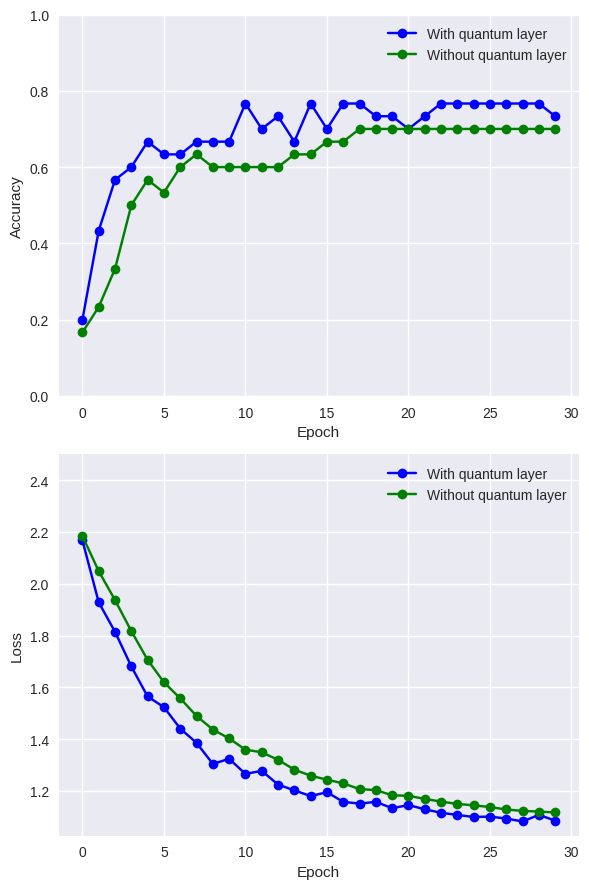

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
